In [1]:
# default_exp nbeats.callbacks

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats Callbacks

> A basic architecture for time series forecasting.


The approach is based on https://arxiv.org/abs/1905.10437


In [3]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [4]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

from fastseq.nbeats.model import *

In [5]:
# export
def CombinedLoss(loss_func, lookback, ratio = [1,1]):
    def _inner(pred, truth, *args, **kwargs):
        if len(pred.shape) == 2:
            pred = pred[:,None,:]
            truth = truth[:,None,:]
        if kwargs.get('reduction', 'mean') == 'none':
            loss = torch.zeros_like(pred)
            loss[:,:,:lookback] += loss_func(pred[:,:,:lookback],truth[:,:,:lookback], *args, **kwargs) * ratio[0]
            loss[:,:,lookback:] += loss_func(pred[:,:,lookback:],truth[:,:,lookback:], *args, **kwargs) * ratio[1]            
        else:
            loss = loss_func(pred[:,:,:lookback],truth[:,:,:lookback], *args, **kwargs) * ratio[0]
            loss += loss_func(pred[:,:,lookback:],truth[:,:,lookback:], *args, **kwargs) * ratio[1]
        return loss
    
    return _inner
  

In [6]:
lookback = 7
y, y_hat = torch.arange(10).float()[None,None,:], torch.arange(10)[None,None,:].float()+torch.randn(10)
loss_fnc = CombinedLoss(F.mse_loss,lookback)
test_eq(F.mse_loss(y[:,:,:7],y_hat[:,:,:7])+F.mse_loss(y[:,:,7:],y_hat[:,:,7:]),loss_fnc(y, y_hat))

r = 10
loss_fnc = CombinedLoss(F.mse_loss, lookback, ratio = [1,r])
loss = loss_fnc(y, y_hat)
test_eq(F.mse_loss(y[:,:,:7],y_hat[:,:,:7])+F.mse_loss(y[:,:,7:],y_hat[:,:,7:])*r,loss)

In [7]:
# hide
y, y_hat = torch.arange(10).float()[None,:], torch.arange(10)[None,:].float()+torch.randn(10)
loss_fnc = CombinedLoss(F.mse_loss,lookback)
test_eq(F.mse_loss(y[:,:7],y_hat[:,:7])+F.mse_loss(y[:,7:],y_hat[:,7:]),loss_fnc(y, y_hat))

In [8]:
horizon, lookback = 10,40
path = untar_data(URLs.m4_daily)
data = TSDataLoaders.from_folder(path, horizon = horizon, lookback = lookback, nrows = 3, step=3)
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback, layers = [100])
loss_func = CombinedLoss(F.mse_loss, lookback)
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam,)
learn.loss_func
learn.fit(2,.1)

torch.Size([1, 1020])
Train:644; Valid: 18; Test 3


epoch,train_loss,valid_loss,time
0,4.678130,3.680904,00:01
1,4.388858,2.525441,00:01


In [9]:
# hide
# reduction == none
loss = torch.cat([F.mse_loss(y[:,:7],y_hat[:,:7],reduction='none'),F.mse_loss(y[:,7:],y_hat[:,7:],reduction='none')],-1)
test_eq(loss[:,None,:],loss_fnc(y, y_hat, reduction='none'))
idx = torch.arange(9)
_ = learn.get_preds(dl=learn.dls[1], with_input=True, with_loss=True, with_decoded=True, act=None)

In [10]:
# export
class NBeatsChangeSizes(Callback):
    """Changes the lookback and horizon to match with the size of batch."""
    def begin_batch(self):
        l = self.xb[0].shape[-1]
        if l != self.learn.model.lookback :
            self.learn.model.lookback = l
            print(f"set lookback to {l}")
        h = self.yb[-1].shape[-1]-self.xb[0].shape[-1]
        if h != self.learn.model.horizon:
            self.learn.model.horizon = h
            print(f"set horizon to {h}")
            

In [11]:
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback, layers = [100])


In [12]:
horizon, lookback = 10, 40
path = untar_data(URLs.m4_daily)
data = TSDataLoaders.from_folder(path, horizon = horizon, lookback = lookback, nrows = 4, step=3)
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback, layers = [500, 250])
loss_func = CombinedLoss(F.mse_loss, lookback)
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam,cbs = NBeatsChangeSizes())
learn.loss_func
learn.fit(3,.1)
test_eq(learn.model.horizon, horizon)
test_eq(learn.model.lookback, lookback)

torch.Size([1, 1020])
Train:677; Valid: 24; Test 4


epoch,train_loss,valid_loss,time
0,6.006886,6.179306,00:01
1,4.851079,3.645842,00:01
2,4.307757,3.102034,00:01


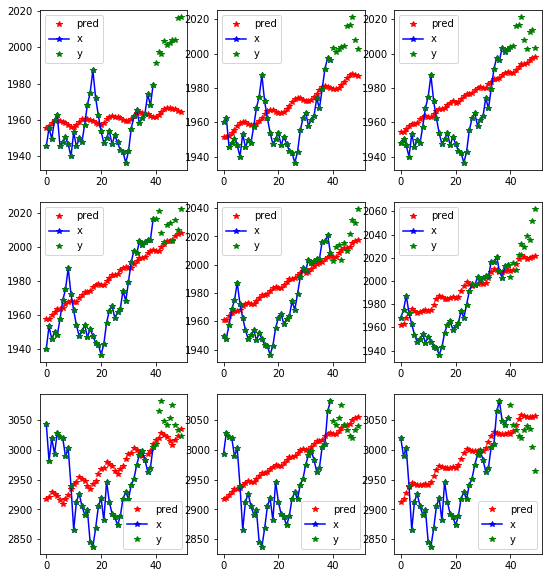

In [13]:
learn.show_results()

torch.Size([1, 1020])
Need to pad 1/3 time series due to length.
Train:581; Valid: 39; Test 3


set horizon to 25


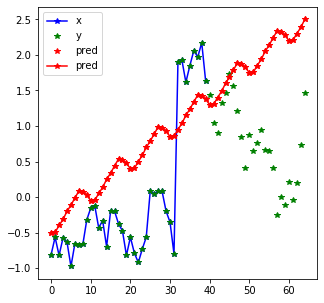

In [14]:
horizon, lookback = 25, 40
path = untar_data(URLs.m4_daily)
data = TSDataLoaders.from_folder(path, horizon = horizon, lookback = lookback, nrows = 3, step=3)
a = learn.get_preds(dl = data.train, with_decoded=True, with_input=True)

ax = TSTensorSeq(a[0][0,:]).show()
TSTensorSeqy(a[2][0,:]).show(ctx=ax)
TSTensorSeqy(a[3][0,:], label='pred',m='*r').show(ctx=ax)
TSTensorSeqy(a[1][0,:], label='pred',m='*-r').show(ctx=ax)
# TSTensorSeqy(a[3][0,:], label='pred',c='r').show(ctx=ax)


In [23]:
learn.show_results(dl = data.train)

RuntimeError: The size of tensor a (64) must match the size of tensor b (24) at non-singleton dimension 0

## Metrics 

In [26]:
#export
class NBeatsLossPart(Metric):
    "The loss according to the `loss_func` on a particular part of the time-serie."
    def __init__(self, start, end, name, *args, loss_func=None, **kwargs):
        store_attr(self,"start,end,loss_func")
        self._name = name
        
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)      
        if self.loss_func is None:
            self.loss_func = learn.loss_func
        pred, truth = learn.pred, learn.yb[0]
        if len(pred.shape) == 2:
            pred = pred[:,None,:]
            truth = truth[:,None,:]
        assert pred[:,0,self.start:self.end].shape == truth[:,0,self.start:self.end].shape 
        loss = to_detach(self.loss_func(pred[:,0,self.start:self.end], truth[:,0,self.start:self.end])) / truth[:,0,self.start:self.end].shape[-1]
        self.total += loss.mean()*bs        
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return self._name

In [33]:
# hide
horizon, lookback = 10,30
items = dummy_data_generator(75, 10, nrows=10)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=3, valid_pct=.5
                               )
data = TSDataLoaders.from_items(items, horizon = horizon,lookback = lookback, bs=32)
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback, layers = [100])
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=[NBeatsLossPart(0,-10,'Last')],
#                 cbs=L(NBeatsTrainer())
               )
learn.loss_func
learn.fit(2,.1)

(1, 85)
Train:70; Valid: 20; Test 10
(1, 85)
Train:110; Valid: 160; Test 10


epoch,train_loss,valid_loss,Last,time
0,2.705139,3.562670,0.105800,00:00
1,2.193836,3.313841,0.096343,00:00


In [28]:
# hide
path = untar_data(URLs.m4_daily)
data = TSDataLoaders.from_folder(path, horizon = horizon, lookback = lookback, nrows = 3, step=3, max_std=5)
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=[NBeatsLossPart(0,-10,'Last')],
#                 cbs=L(NBeatsTrainer())
               )
learn.loss_func
learn.fit(2,.1)

torch.Size([1, 1020])
Train:644; Valid: 18; Test 3


epoch,train_loss,valid_loss,Last,time
0,3.558412,2.243824,0.038603,00:01
1,2.683915,1.832321,0.030807,00:01


In [29]:
#export
class NBeatsBackward(NBeatsLossPart):
    "The loss according to the `loss_func` on the backwards part of the time-serie."    
    def __init__(self, lookback, *args, **kwargs):
        super().__init__(0, lookback, 'b_loss', *args, **kwargs)

In [34]:
# hide
horizon, lookback = 5,20
items = dummy_data_generator(50, 10, nrows=10)
data = TSDataLoaders.from_items(items, horizon = horizon,lookback = lookback, bs=32)
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback, layers = [100])
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, #metrics=[NBeatsBackward(lookback)],
#                 cbs=L(NBeatsTrainer())
               )
learn.loss_func
learn.fit(2,.1)

(1, 60)
Train:190; Valid: 80; Test 10


epoch,train_loss,valid_loss,time
0,1.283422,1.268886,00:00
1,1.104555,1.149982,00:00


In [35]:
#export
class NBeatsForward(NBeatsLossPart):
    "The loss according to the `loss_func` on the forward part of the time-serie."  
    def __init__(self, lookback, *args, **kwargs):
        super().__init__(lookback, None, 'f_loss', *args, **kwargs)

In [36]:
# hide
items = dummy_data_generator(50, 10, nrows=3)
data = TSDataLoaders.from_items(items, horizon = horizon,lookback = lookback, bs=32)
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback, layers = [100])
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=[NBeatsForward(lookback)],
               )
learn.loss_func
learn.fit(3,.1)
test_eq(type(learn.metrics[0].value), Tensor)

(1, 60)
Train:57; Valid: 24; Test 3


epoch,train_loss,valid_loss,f_loss,time
0,2.119546,1.693114,0.643393,00:00
1,1.999058,1.830911,0.525921,00:00
2,1.788922,1.247476,0.474041,00:00


In [37]:
path = untar_data(URLs.m4_daily)
data = TSDataLoaders.from_folder(path, horizon = horizon, lookback = lookback, nrows = 1, step=3, )
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback, layers = [100])
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=L(None)+L(mae, smape, 
                                         NBeatsBackward(lookback), NBeatsForward(lookback)),)

learn.fit(3, .1)

torch.Size([1, 1020])
Train:327; Valid: 3; Test 1


epoch,train_loss,valid_loss,mae,smape,b_loss,f_loss,time
0,1.201533,1.721093,0.935713,1.019105,0.031540,1.216456,00:00
1,1.050859,1.206644,0.808499,0.966173,0.023748,0.826671,00:00
2,0.983588,1.152934,0.793493,0.968807,0.022994,0.785033,00:00


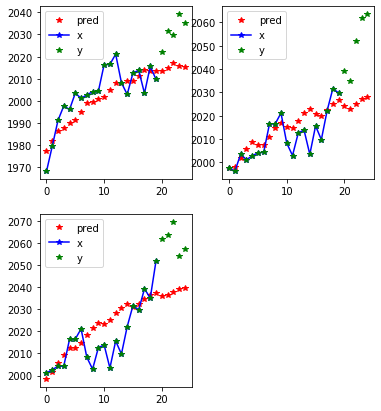

In [38]:
learn.show_results()

In [57]:
# export
from fastseq.metrics import *

class BackwardSMAPE(NBeatsLossPart):
    "The SMAPE on the backwards part of the time-serie."

    def __init__(self, lookback, *args, **kwargs):
        super().__init__(0, lookback, "b_smape", *args, loss_func=smape, **kwargs)


class ForwardSMAPE(NBeatsLossPart):
    "The SMAPE on the forwards part of the time-serie."

    def __init__(self, lookback, *args, **kwargs):
        super().__init__(lookback, None, "f_smape", *args, loss_func=smape, **kwargs)


In [54]:
# hide
# TODO mase

In [52]:
# hide
items = dummy_data_generator(50, 10, nrows=3)
data = TSDataLoaders.from_items(items, horizon = horizon,lookback = lookback, bs=32)
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback, layers = [100])
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=[BackwardSMAPE(lookback), ForwardSMAPE(lookback)],
               )
learn.loss_func
learn.fit(3,.1)
test_eq(type(learn.metrics[0].value), Tensor)

(1, 60)
Train:126; Valid: 12; Test 3


epoch,train_loss,valid_loss,b_smape,f_smape,time
0,1.897049,1.414328,0.132861,0.628999,00:00
1,1.531051,0.889353,0.115490,0.394242,00:00
2,1.342998,0.584557,0.111781,0.369091,00:00


In [53]:
path = untar_data(URLs.m4_daily)
data = TSDataLoaders.from_folder(path, horizon = horizon, lookback = lookback, nrows = 1, step=3, )
mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback, layers = [100])
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=L(None)+L(mae, smape, 
                                         BackwardSMAPE(lookback), ForwardSMAPE(lookback)),)

learn.fit(3, .1)

torch.Size([1, 1020])
Train:334; Valid: 2; Test 1


epoch,train_loss,valid_loss,mae,smape,b_loss,f_loss,time
0,1.626564,0.531735,0.611273,1.127493,0.056581,0.180685,00:00
1,1.354240,0.448775,0.545311,0.951489,0.050076,0.094422,00:00
2,1.241490,0.454662,0.575566,1.042800,0.050171,0.109699,00:00


## Other

In [39]:
# export
def _get_key_from_nested_dct(dct, s_key, exclude = [], namespace=''):
    r = {}
    for key in dct.keys():
        if sum([exc in key for exc in exclude])== 0 :
            if type(dct[key]) == dict:
                r.update(_get_key_from_nested_dct(dct[key], s_key, exclude, namespace=namespace+key))
            if s_key in key:
                r[namespace+key] = dct[key]
    return r

In [40]:
dct = {'foo':{'bar':1},'bar':2,'foo2':{'foo3':3},'ignore':{'bar':1000}}
r = _get_key_from_nested_dct(dct,'bar',['ignore'])
test_eq(r,{'foobar': 1, 'bar': 2})

In [41]:
#export
class NBeatsTheta(Metric):
    "The sqaure of the `theta` for every block. "
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)   
        theta_dct = _get_key_from_nested_dct(learn.model.dct,'theta',['bias','total','att'])
        t = torch.sum(tensor([v.float().abs().mean() for k,v in theta_dct.items()]))
        self.total += to_detach(t.abs().mean())*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "theta"

In [42]:
horizon, lookback = 7,10
path = untar_data(URLs.m4_daily)
data = TSDataLoaders.from_folder(path, horizon = horizon, lookback = lookback, nrows = 1, step=3, max_std=5)

mdl = NBeatsNet(device = data.train.device, horizon=horizon, lookback=lookback, layers = [100])
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=[NBeatsTheta()],
               )

learn.fit(3,.1)
test_eq(type(learn.metrics[0].value),Tensor)

torch.Size([1, 1020])
Train:327; Valid: 4; Test 1


epoch,train_loss,valid_loss,theta,time
0,3.218897,3.638505,1.559033,00:00
1,3.042957,3.146926,1.094095,00:00
2,2.959047,3.188194,1.110073,00:00


## Callbacks

In [43]:
# export
class NBeatsAttention(Callback):  
    def means(self, df=True):
        theta_means = {k.replace('theta',''):v.float().cpu().data for k,v in _get_key_from_nested_dct(self.learn.model.dct,'theta',['total']).items()}
        ret = {}
        for k,v in theta_means.items():
            ret[k] = {}
            for i in range(v.shape[-1]):
                ret[k].update({'theta_'+str(i)+'_mean': v[:,i].mean().numpy(),
                               'theta_'+str(i)+'_std': v[:,i].std().numpy(),
                              })
            
        att = {k.replace('attention','att_mean'):v.float().cpu().numpy() for k,v in _get_key_from_nested_dct(self.learn.model.dct,'att',['total']).items()}
        for k in ret.keys():
            for att_key in att.keys():
                if k in att_key:
                    ret[k].update({'att_mean':att[att_key].mean(),
                                   'att_std':att[att_key].std(),
                                  })
                
        if df:
            return pd.DataFrame(ret)
        return ret

In [45]:
horizon, lookback = 7,10
items = L(np.arange(-5,100)[None,:],np.arange(500,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                             )
mdl = NBeatsNet(device = data.train.device,horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=L(mae, smape, NBeatsTheta(), 
                                         NBeatsBackward(lookback), NBeatsForward(lookback)),
                cbs=L( NBeatsAttention()
                     )
               )
learn.fit(3,.1)
df = learn.n_beats_attention.means()
df

torch.Size([1, 105])
Train:89; Valid: 33; Test 3


epoch,train_loss,valid_loss,mae,smape,theta,b_loss,f_loss,time
0,7.063035,6.239435,2.075063,1.390074,2.909513,0.335390,1.480233,00:00
1,7.443372,8.091285,2.275772,1.553161,3.219479,0.366179,2.059876,00:00
2,7.676329,6.378671,2.065759,1.593280,2.533737,0.286700,1.627907,00:00


,trend0_0,trend0_1,seasonality1_0,seasonality1_1,seasonality1_2,seasonality1_3
theta_0_mean,0.0,0.0,2.2499769,0.24990746,-2.25,0.0
theta_0_std,0.0,0.0,0.0,0.0,0.0,0.0
theta_1_mean,0.005,1.846627e-06,-0.025963232,-0.5625,0.0,0.0
theta_1_std,0.0,0.0,5.350041e-09,0.0,0.0,0.0
theta_2_mean,0.0,0.0,0.0,0.25,-0.140625,0.0
theta_2_std,0.0,0.0,0.0,0.0,0.0,0.0
theta_3_mean,-0.14988667,-0.0004500001,NaN,0.5625,2.25,2.25
theta_3_std,0.0,0.0,NaN,0.0,0.0,0.0
theta_4_mean,0.0,-0.14941214,NaN,NaN,0.0,0.0
theta_4_std,0.0,0.0,NaN,NaN,0.0,0.0


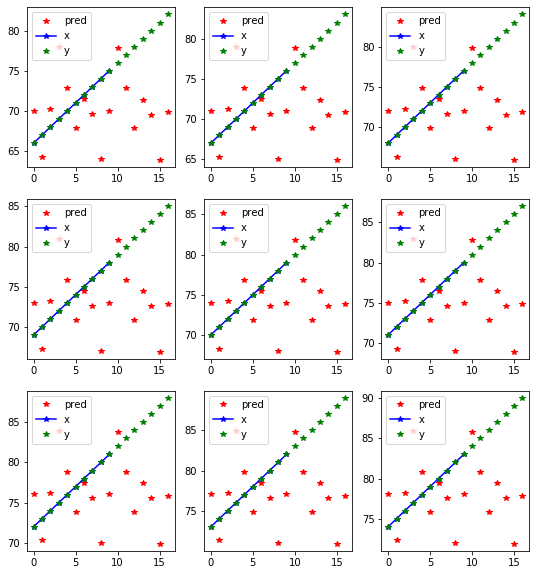

In [46]:
learn.show_results()

In [47]:
# export
class ClipLoss(Callback):
    "`Callback` that adds weights regularization the thetas in N-Beats training."
    def __init__(self, clip=5):
        self.clip = tensor([clip])

    def after_loss(self):
        self.learn.loss = torch.clamp(self.learn.loss, 0, self.clip.numpy()[0])
        
#     def after_backward(self):
#         nn.utils.clip_grad_norm_(self.learn.model.parameters(), self.clip)

torch.Size([1, 35])
Train:49; Valid: 8; Test 2


epoch,train_loss,valid_loss,time
0,1.439459,2.123430,00:00
1,2.391775,5.000000,00:00
2,3.278804,5.000000,00:00
3,3.722229,5.000000,00:00
4,3.988210,3.264698,00:00
5,4.165472,3.354544,00:00
6,4.292035,3.529953,00:00
7,4.386912,5.000000,00:00
8,4.460666,5.000000,00:00
9,4.519632,5.000000,00:00


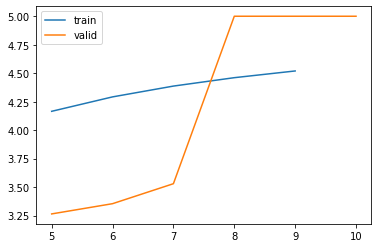

In [48]:
horizon, lookback = 2,10
items = L(np.arange(-5,30)[None,:],np.arange(50)[None,:]).map(tensor)
items[-1][:,-8:-5] = 1e10
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                             )
mdl = NBeatsNet(device = data.train.device,horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, 
                cbs=L(ClipLoss()
                     )
               )

learn.fit(10,.1)
learn.recorder.plot_loss()

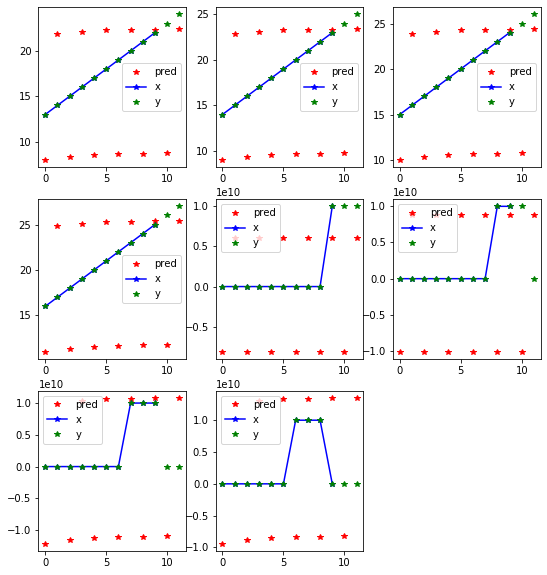

In [49]:
learn.show_results()

In [ ]:
# hide
# old stuff
###################################################
###################################################

In [ ]:
# hide
class NBeatsBLoss(Callback): 
    def __init__(self,alpha = 1):store_attr(self,'alpha')
    def after_loss(self):
#         print('pre',self.learn.loss,self.n_beats_trainer.out['total_b_loss'].mean())
        self.learn.loss = self.learn.loss + self.n_beats_trainer.out['total_b_loss'].mean()*self.alpha
#         print('after',self.learn.loss)

In [ ]:
# hide
horizon, lookback = 7,30
items = L(np.arange(-5,100)[None,:],np.arange(250,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                               )
thetas_dim= (2,4)
mdl = NBeatsNet(device = data.train.device, nb_blocks_per_stack = 1, horizon=horizon, lookback=lookback, thetas_dim=thetas_dim)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics = [smape,NBeatsBackwards(lookback)],
                cbs=L(NBeatsAttention(),
                     )
               )

In [ ]:
# hide
# test_eq(list(df.columns),[o+str(i)+'_0' for i,o in enumerate(stack_types)])
# test_eq('att_mean' in list(df.axes[0]), True)
# test_eq('att_std' in list(df.axes[0]), True)

In [ ]:
# hide
# TODO maybe add extra backwards loss also in a callback??
class NBeatsTrainer(Callback):
    "`Callback` that adds weights regularization the thetas in N-Beats training."
    def __init__(self, theta=0., b_loss=0.): 
        self.theta, self.b_loss = theta, b_loss
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        self.b = None

    def begin_train(self): 
        self.out = defaultdict(dict)
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        
    def begin_validate(self): 
        self.out = defaultdict(dict)
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        
    def after_pred(self):
        self.b = self.pred[1] 
        self.pred[2]['total_b'] = self.pred[1] 
        self.out = concat_dct(self.pred[2], self.out)   
        self.learn.pred = self.pred[0]

    def after_loss(self):        
        # theta
        value=tensor([0.])
        for key in self.out.keys():
            if 'bias' not in key and 'total' not in key and 'att' not in key:
                v = self.out[key]['theta'].float().pow(2).mean()
                if self.theta != 0.:     
                    self.learn.loss += self.theta * v.item()
                value = value + v
        self.metrics['theta'] += value.clone().cpu().detach()
        
        # backwards 
        value = self.learn.loss_func(self.b.float(), *self.xb, reduction='mean') 
        if self.b_loss != 0.:
            self.learn.loss += self.b_loss * value.mean() 
        self.metrics['b_loss'] += value.sum().clone().detach()
            


In [66]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
